### Beschrijving Buurtscores Decision Tree EE


Maak een decision tree model op de buurten die door de expert EE zijn beoordeeld, met als doel om te kunnen achterhalen hoe hij de beslissingen heeft gemaakt.
<br>

Gebruik makend van een basic CART uit scikit-learn.
<br>

Decision Tree modelleert buurtoordeel A, B of C en is een classifier. 
Aan het eind ook nog een variant (geen classifier maar regressor) die WOX voorspelt - geen opvolging. 

Input: 
- buurten: bm, wm, gm aan elkaar gekoppeld (betreft alle buurten)
- buurtoordeel experts (betreft een kleine selectie van ca 320 buurten)

Output per tree: 
- een afbeelding van de tree
- Excel met verschillen tussen voorspelling en werkelijke oordeel expert
- Excel met tree toegepast op alle buurten

### Declaraties

In [1]:
# importeren packages
import pandas as pd
import numpy as np
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

# graphviz ook apart installeren en toevoegen in path zie insructies https://stackoverflow.com/questions/45729624/graphvizs-executables-not-found-anaconda-3

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

source_path ="Q:\\RESEARCH\\RESEARCH ALGEMEEN\\Aantrekkelijkheid buurten\\DS project 2020\\Resultaten\\"
save_path = "Q:\RESEARCH\RESEARCH ALGEMEEN\\Aantrekkelijkheid buurten\\DS project 2020\\Resultaten\\"

## Inladen data

Moet straks gemaakt worden dat het aansluit op de rest van de bestanden in de scripts, al het excel gedoe er tussenuit gooien

In [2]:
# van de expert bestanden zullen we alleen de oordelen gebruiken
df = pd.read_excel(source_path+'buurten voor experts 2e ronde.xlsx', sheet_name='buurten')

# inlezen alle buurten waarbij de andere kolommen worden opgehaald en waardoor later het model kan worden losgelaten op alle buurten
buurten = pd.read_csv(source_path+'buurten.csv', encoding='utf-16')

## data preparatie

#### Character types

In [3]:
#df.info()
#buurten.info()

### Samenvoegen df met oordelen en buurtinfo
dfExp: alleen beoordeelde buurten<br>
dfAlles: alle buurten

In [4]:
# df met expert oordelen: slechts 3 kolommen overhouden
keepcols = ['buurtcode', 'TK', 'EE'] 
df = df[keepcols]

# buurten: toevoegen kolom banen
buurten['banen']=(buurten['auto30']+ buurten['ov30']+buurten['fiets'])/3
# verwijderen kolommen waar we hoe dan ook niet verder mee willen gaan
delcols = ['buurtcode18', 'buurtcodeLetters18', 'buurtcodeLettersMatch', 
           'RLBRMTR16', 'RLBWON16', 'RLBBEV16', 'RLBVRZ16', 'RLBFYS16', 'RLBVEI16',
            'sleutel', 
            'wvtotaal', 'wv<1945', 'wv1945-1970', 'wv1970-1980', 'wv1980-1990', 'wv1990-2000', 'wv2000-2010', 'wv>=2010',
            'aand1945-1970', 'aand1970-1980', 'aand1980-1990', 'aand1990-2000', 'aand2000-2010','aand>=2010', 
            'ar30', 'ar60', 'door30', 'door60']
buurten = buurten.drop(delcols, axis=1)
print(buurten.head())

# aanvullen expert oordelen met info uit buurten
dfExp  = pd.merge(df, buurten, how='inner', on='buurtcode')
dfExp.replace('', np.nan, inplace=True)
# aanmaken dataframe met alle buurten en alle info excl delcols, inclusief de oordelen van TK en EE
dfAlles = pd.merge(buurten, df, how = 'left', on ='buurtcode')
dfAlles.replace('', np.nan, inplace=True)

print(dfExp.info())
print(dfAlles.info())

   buurtcode                                    buurtnaam buurtcodeLetters  \
0      30000                           Appingedam-Centrum       BU00030000   
1      30001                              Appingedam-West       BU00030001   
2      30002                              Appingedam-Oost       BU00030002   
3      30007  Verspreide huizen Damsterdiep en Eemskanaal       BU00030007   
4      30008  Verspreide huizen ten zuiden van Eemskanaal       BU00030008   

   wijkcode wijknaam  gemeentecode gemeentenaam   inw   bevdh    oadh  \
0       300  Wijk 00             3   Appingedam  2370  2812.0  1210.0   
1       300  Wijk 00             3   Appingedam  3035  1922.0   903.0   
2       300  Wijk 00             3   Appingedam  5725  2012.0  1140.0   
3       300  Wijk 00             3   Appingedam   325    60.0   359.0   
4       300  Wijk 00             3   Appingedam   100    18.0    79.0   

       ...       woxGem  woxdelta1jrGem  woxdelta5jrGem  woxwwGem  woxm2Gem  \
0      ...   

### MaakTree method definiëren die boom maakt aan de hand van een lijst parameters en diverse output genereert
Parameter vast: minimale leaf size 10<br>Maakt gebruik van globaal bekende: dfExp en dfAlles<br>
Retourneert: clf object

In [5]:
def maakTree(feature_cols, diepte, minleafsize, expert, testaandeel, random, omschrijving):
    
    # verwijderen rijen waarbij niet alle feature_cols gevuld zijn anders werkt het niet. 
    
    # Om juiste aansluiting met voorspellingen eruit te halen wordt er een nieuwe dfExp afgeleid, als ook om de oorspronkelijke
    # dfExp in tact te laten.
    dfExpNu = dfExp
    
    # toevoegen kolom expert aan feature_cols
    feature_cols.append(expert)
    dfExpNu = dfExpNu[feature_cols].dropna()
    print('Aantal rijen uit expert dataset dat gebruikt wordt: ', len(dfExpNu), 'van totaal aantal rijen: ', len(dfExp))
    # weer verwijderen van kolom export uit feature_cols
    del feature_cols[-1]
    
    # maken X en Y
    X = dfExpNu[feature_cols] # features
    y = dfExpNu[expert] # target variable TK of EE
    
    # Splits dataset in training set en test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testaandeel, random_state=random)
    
    # maak decision tree classifier object
    clf = DecisionTreeClassifier(max_depth=diepte, min_samples_leaf=minleafsize)
    
    # train Decision Tree Classifiers
    clf = clf.fit(X_train,y_train)
    
    # maak met clf de voorspelling op observaties in X_test
    y_pred = clf.predict(X_test)
    
    # bereken accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print('Accuracy: ', accuracy, 'bij variant: ', omschrijving)
    
    # visualisatie van tree
    dot_data = StringIO()
    export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=feature_cols)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    #dit werkt niet hier: Image(graph.create_png())
    # opslaan in file werkt wel hier. Geef een herkenbare omschrijving mee zodat goed kan worden vergeleken.
    graph.write_png(save_path+'\\Bomen\\'+omschrijving+str("%.2f" % accuracy)+'.png')
    
    # de voorspellingen naast de oorspronkelijke waarden zetten.
    # y pred is een array; maak er een dataframe van
    preddf = pd.DataFrame(y_pred)
    # kolomnaam geven
    preddf.columns=['voorspeld']
    # samenvoegen X en oorspronkelijke y
    voorspeld = pd.concat([X_test, y_test], axis = 1)
    # drop index anders gaat mergen fout
    voorspeld.reset_index(drop=True, inplace=True)
    # toevoegen voorspelde Y
    voorspeld2 = pd.concat([voorspeld, preddf], axis=1)
    # selecteren en afdrukken mismatches en opslaan in XLSX
    afwijking = voorspeld2[voorspeld2[expert]!=voorspeld2['voorspeld']]
    afwijking.to_excel(save_path +'\\Bomen\\Afw'+omschrijving+str("%.2f" % accuracy)+'.xlsx')
    
    # classifier toepassen op gehele dataset. Eerst rijen met missing values uitsluiten en alleen de feature columns gebruiken. 
    # LET OP. Er wordt dus geen oordeel gegeven op rijen waarvoor dat niet mogelijk is. Dat betekent ook dat de resultaaat
    # dataset niet compleet is.
    X_alles = dfAlles[feature_cols].dropna()
    print('Aantal buurten dat een oordeel heeft gekregen: ', len(X_alles), 'van totaal: ', len(dfAlles))
    # classifier toepassen op overblijvende dataset
    allepred=clf.predict(X_alles)
    # samenvoegen. alle pred is een array, maak er een dataframe van
    allepreddf = pd.DataFrame(allepred)
    # kolomnaam geven
    allepreddf.columns=['voorspeld']
    #drop index anders gaat mergen fout
    X_alles.reset_index(drop=True, inplace=True)
    # toevoegen voorspelde Y
    voorspeldAlles = pd.concat([X_alles, allepreddf], axis=1)
    # wederom opslaan in XLSX (sorry Alex)
    voorspeldAlles.to_excel(save_path +'\\Bomen\\Alles'+omschrijving+str("%.2f" % accuracy)+'.xlsx')
    
    return clf

#### Parameters bepalen en aanroepen functie die tree maakt, verschillende varianten

Aantal rijen uit expert dataset dat gebruikt wordt:  316 van totaal aantal rijen:  338
Accuracy:  0.8842105263157894 bij variant:   d3 l20 selcols EE 
Aantal buurten dat een oordeel heeft gekregen:  6383 van totaal:  13624


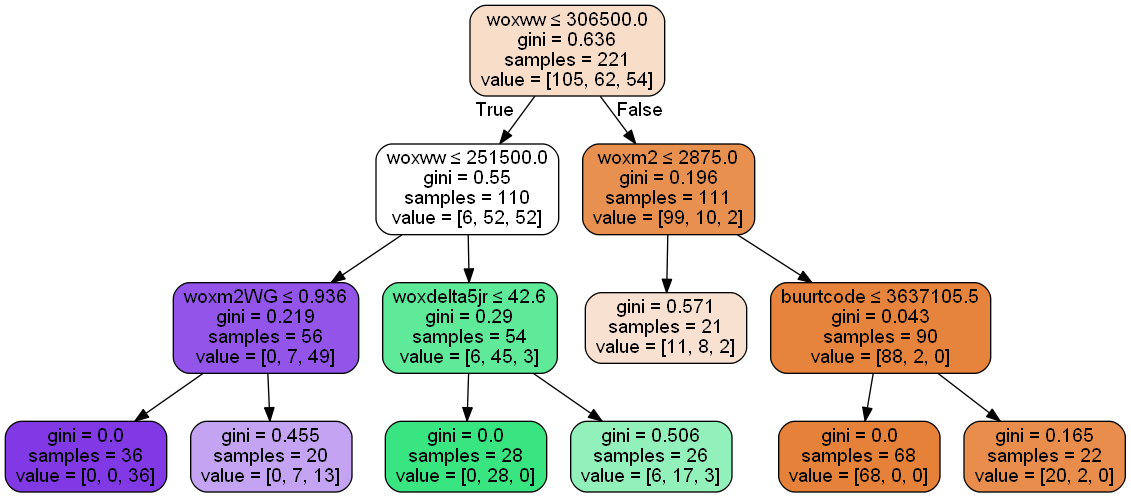

In [26]:
# max diepte 3, expert EE, beperkte selectie aan feature_cols
# resultaat: interessante boom, volledig obv WOX bij minleafsize 1, bij minleafsize 20 komt buurtcode erbij maar blijft alles A

# diepte voor max_depth: aantal nodes een integer of None
diepte=3
minleafsize = 20
# expert: TK of EE. Dit wordt ook de independent variabele. 
expert='EE'
# testaandeel: voor test_size, percentage dat gebruikt wordt voor de test. Tussen 0 en 0.5. 
# De rest wordt dan gebruikt voor de trainingset.
testaandeel = 0.3
# kandidaat kolommen. Dit kan ook alles zijn, dan wel opsommen. 
# buurtcode een vreemde eend in de bijt maar handig om later verschillen te zien bv.
feature_cols = ['buurtcode', 'oadh', 'AfstandSupermarkt', 'AantalLevensm3', 'AantalRest3', 'AantalPodiumk10', 'banen', 
               'woxww','woxdelta5jr', 'woxdelta5jrWGrel','woxm2', 'woxm2WG']
# varieer met dit getal om nieuwe splitsing te maken en daarmee ook andere resultaten
random = 1

# alleen wox kolommen:
#feature_cols = ['woxww','woxdelta5jr', 'woxdelta5jrWGrel','woxm2', 'woxm2WG']
# zonder wox kolommen:
#feature_cols = ['oadh', 'AfstandSupermarkt', 'AantalLevensm3', 'AantalRest3', 'AantalPodiumk10', 'banen']

omschrijving =' d3 l20 selcols EE '
clf=maakTree(feature_cols, diepte, minleafsize, expert, testaandeel, random, omschrijving)
# statement om Image af te drukken moet buiten de method
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=feature_cols)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Aantal rijen uit expert dataset dat gebruikt wordt:  296 van totaal aantal rijen:  338
Accuracy:  0.7752808988764045 bij variant:   d3 l10 zonderWox EE 
Aantal buurten dat een oordeel heeft gekregen:  10441 van totaal:  13624


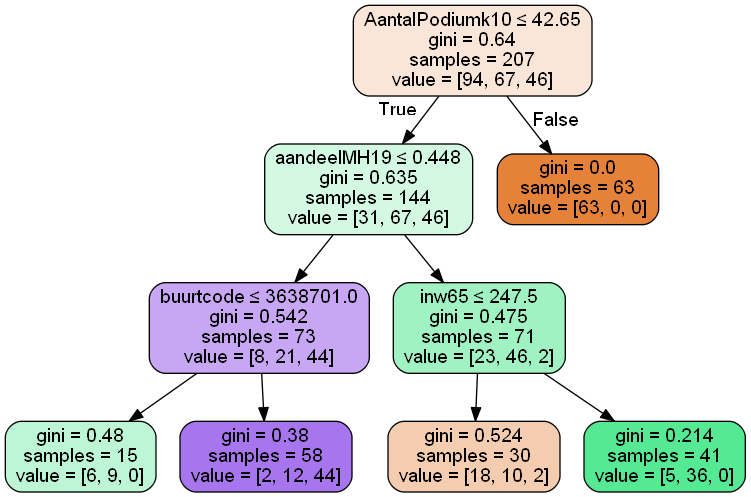

In [27]:
# EE zonder wox variabelen om de match met de totale lijst te vergroten
# resultaat: lagere accuracy en vreemde node met buurtcode en idee dat we te veel nuances missen door verwijderen wox. 
diepte=3
minleafsize=1
expert='EE'
testaandeel = 0.3
random = 2
# alle kolommen excl wox, enkele omschrijvingen, onnodige wijkcodes, marktpotentie want String, enkele variabelen die toch niet 
# bepalend zullen zijn maar wel zorgen voor verwijderen van obs. (eerst 292 vd 338 en acc 0.79 waaronder buurtcde. daarna 296 vd 338 en acc 0.77)
feature_cols = ['buurtcode','inw', 'bevdh', 'oadh', 'hh', 'inw65', 'KL18', 'RLBRMTR18', 'RLBWON18', 'RLBBEV18', 'RLBVRZ18', 'RLBVEI18', 'RLBFYS18', 
                'AfstandSupermarkt', 'AantalLevensm3', 'AfstandHuisarts', 'AantalCafe3','AantalRest3', 'AantalKinderopvang1', 
                'AfstandZwembad', 'AantalMusea10', 'AantalPodiumk10', 'AantalBios5', 
                'hh19inkLaag', 'hh19inkMidden', 'hh19inkHoog', 'aandeelMH19', 
                'auto30', 'auto60', 'ov30', 'ov60', 'fiets', 'banen'] 

omschrijving =' d3 l10 zonderWox EE '
clf=maakTree(feature_cols, diepte, minleafsize, expert, testaandeel, random, omschrijving)
# statement om Image af te drukken moet buiten de method
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=feature_cols)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Aantal rijen uit expert dataset dat gebruikt wordt:  292 van totaal aantal rijen:  338
Accuracy:  0.8863636363636364 bij variant:   d10 l1 EE 
Aantal buurten dat een oordeel heeft gekregen:  5621 van totaal:  13624


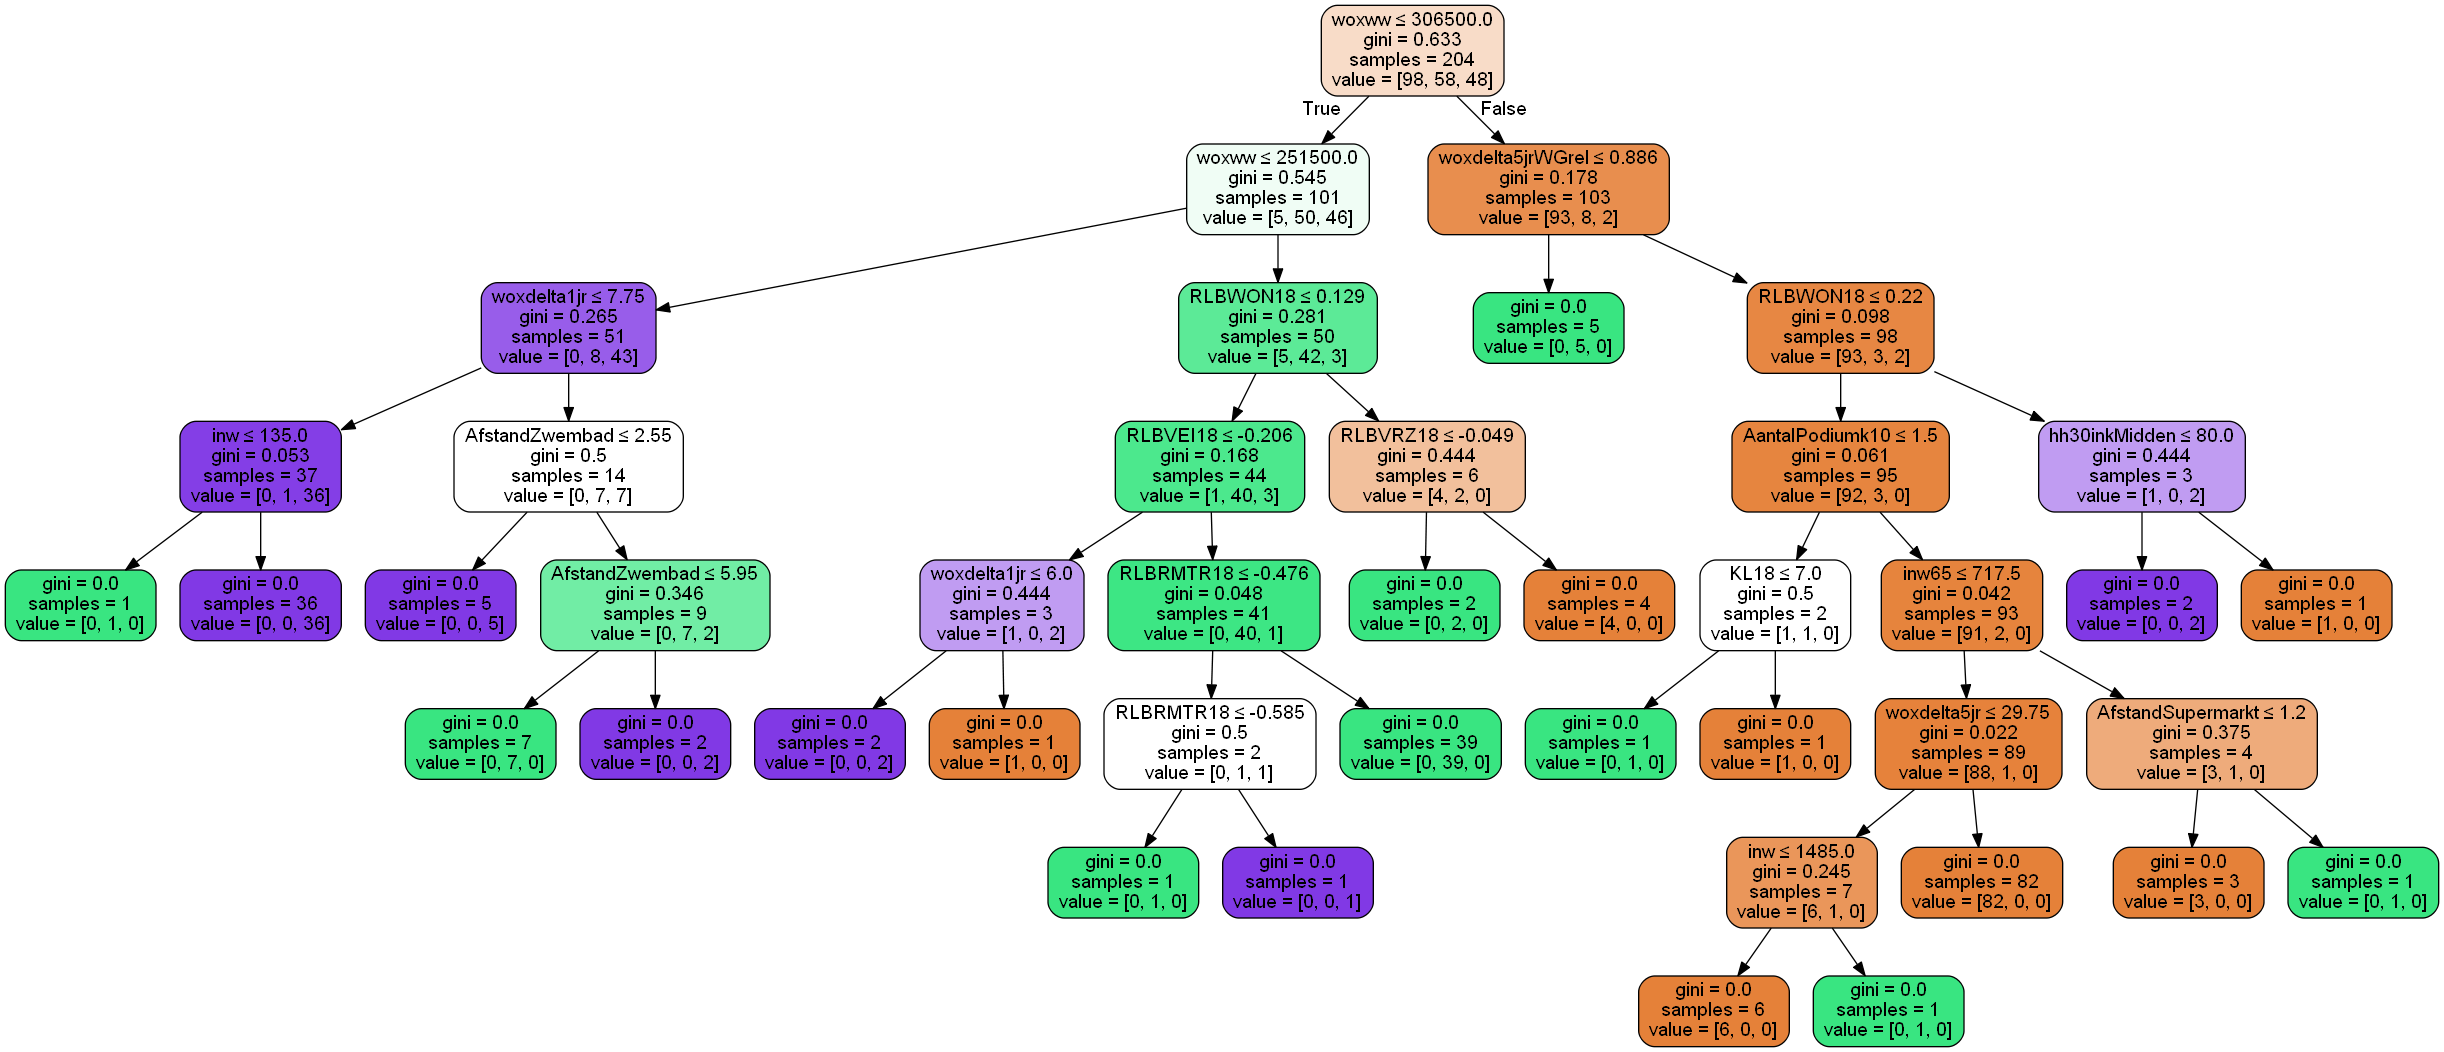

In [35]:
# EE zonder beperkingen in variabelen, max depth 4
# resultaat: mooie mix van wox en overige variabelen, uitstekende kandidaat voor definitieve versie, accuracy niet maximaal
# bij leaf size 10. Bij leaf size 20 betere accuracy 
diepte=10
minleafsize=1
expert='EE'
testaandeel = 0.3
random = 1
# alle kolommen! behalve enkele omschhrijvingen, onnodige wijkcodes, marktpotentie want String 
feature_cols = ['buurtcode','inw', 'bevdh', 'oadh', 'hh', 'inw65', 'KL16', 'KL18', 'VKL1618',
                'RLBRMTR18', 'RLBWON18', 'RLBBEV18', 'RLBVRZ18', 'RLBVEI18', 'RLBFYS18', 
                'AfstandSupermarkt', 'AantalLevensm3', 'AfstandHuisarts', 'AantalCafe3','AantalRest3', 'AantalKinderopvang1', 
                'AfstandZwembad', 'AantalMusea10', 'AantalPodiumk10', 'AantalBios5', 
                'hh19inkLaag', 'hh30inkLaag', 'hh19inkMidden', 'hh30inkMidden', 'hh19inkHoog', 'hh30inkHoog', 
                'aandeelMH19', 'auto30', 'auto60', 'ov30', 'ov60', 'fiets', 
                'wox', 'woxdelta1jr', 'woxdelta5jr', 'woxww', 'woxm2', 
                'woxGem', 'woxdelta1jrGem', 'woxdelta5jrGem', 'woxwwGem', 'woxm2Gem', 'woxdelta5jrWGabs', 'woxdelta5jrWGrel', 
                'woxm2WG','banen'] 


omschrijving =' d10 l1 EE '
clf=maakTree(feature_cols, diepte, minleafsize, expert, testaandeel, random, omschrijving)
# statement om Image af te drukken moet buiten de method
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=feature_cols)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

aantal rijen voor opschonen:  338
aantal rijen na opschonen:  292
accuracy:  0.8977272727272727
Aantal observaties met gevulde rijen:  5621 van totaal:  13624


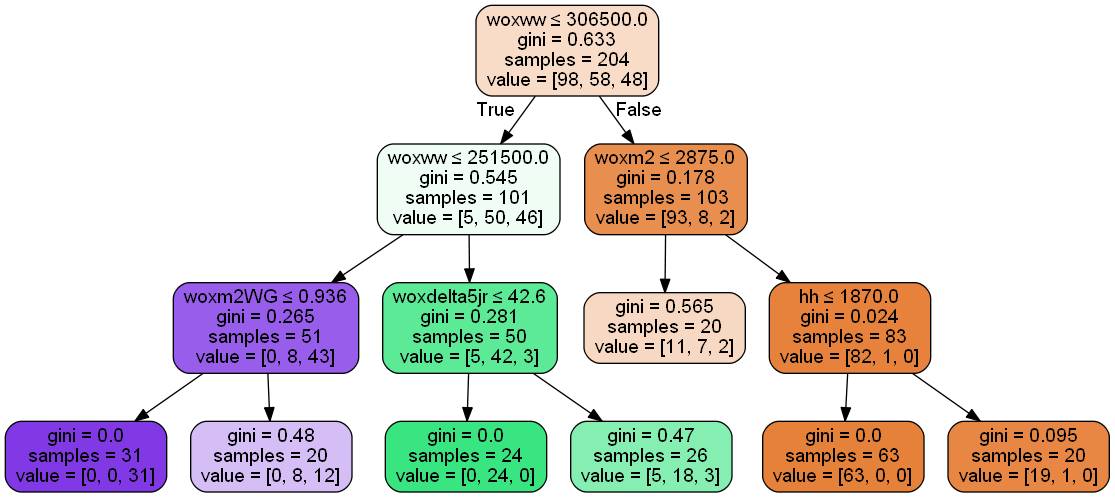

In [19]:
# EE zonder beperkingen in variabelen, max depth 3, leaf size 20
diepte=5
minleafsize=20
expert='EE'
testaandeel = 0.3
random = 1
# alle kolommen! behalve enkele omschhrijvingen, onnodige wijkcodes, marktpotentie want String 
feature_cols = ['buurtcode','inw', 'bevdh', 'oadh', 'hh', 'inw65', 'KL16', 'KL18', 'VKL1618',
                'RLBRMTR18', 'RLBWON18', 'RLBBEV18', 'RLBVRZ18', 'RLBVEI18', 'RLBFYS18', 
                'AfstandSupermarkt', 'AantalLevensm3', 'AfstandHuisarts', 'AantalCafe3','AantalRest3', 'AantalKinderopvang1', 
                'AfstandZwembad', 'AantalMusea10', 'AantalPodiumk10', 'AantalBios5', 
                'hh19inkLaag', 'hh30inkLaag', 'hh19inkMidden', 'hh30inkMidden', 'hh19inkHoog', 'hh30inkHoog', 
                'aandeelMH19', 'auto30', 'auto60', 'ov30', 'ov60', 'fiets', 
                'wox', 'woxdelta1jr', 'woxdelta5jr', 'woxww', 'woxm2', 
                'woxGem', 'woxdelta1jrGem', 'woxdelta5jrGem', 'woxwwGem', 'woxm2Gem', 'woxdelta5jrWGabs', 'woxdelta5jrWGrel', 
                'woxm2WG','banen'] 


omschrijving =' d3 l20 EE '
clf=maakTree(feature_cols, diepte, minleafsize, expert, testaandeel, random, omschrijving)
# statement om Image af te drukken moet buiten de method
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=feature_cols)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

aantal rijen voor opschonen:  338
aantal rijen na opschonen:  292
accuracy:  0.875
Aantal observaties met gevulde rijen:  5621 van totaal:  13624


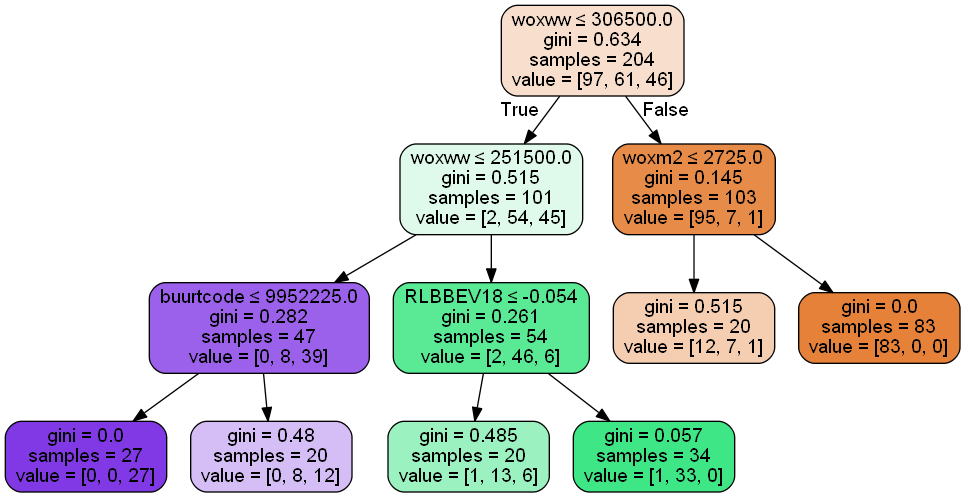

In [20]:
# EE zonder beperkingen in variabelen, max depth 3
diepte=3
minleafsize=20
expert='EE'
testaandeel = 0.3
random = 2
# alle kolommen! behalve enkele omschhrijvingen, onnodige wijkcodes, marktpotentie want String 
feature_cols = ['buurtcode','inw', 'bevdh', 'oadh', 'hh', 'inw65', 'KL16', 'KL18', 'VKL1618',
                'RLBRMTR18', 'RLBWON18', 'RLBBEV18', 'RLBVRZ18', 'RLBVEI18', 'RLBFYS18', 
                'AfstandSupermarkt', 'AantalLevensm3', 'AfstandHuisarts', 'AantalCafe3','AantalRest3', 'AantalKinderopvang1', 
                'AfstandZwembad', 'AantalMusea10', 'AantalPodiumk10', 'AantalBios5', 
                'hh19inkLaag', 'hh30inkLaag', 'hh19inkMidden', 'hh30inkMidden', 'hh19inkHoog', 'hh30inkHoog', 
                'aandeelMH19', 'auto30', 'auto60', 'ov30', 'ov60', 'fiets', 
                'wox', 'woxdelta1jr', 'woxdelta5jr', 'woxww', 'woxm2', 
                'woxGem', 'woxdelta1jrGem', 'woxdelta5jrGem', 'woxwwGem', 'woxm2Gem', 'woxdelta5jrWGabs', 'woxdelta5jrWGrel', 
                'woxm2WG','banen'] 

omschrijving ='d3 l20 EE '
clf=maakTree(feature_cols, diepte, minleafsize, expert, testaandeel, random, omschrijving)
# statement om Image af te drukken moet buiten de method
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=feature_cols)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Aantal rijen uit expert dataset dat gebruikt wordt:  296 van totaal aantal rijen:  338
Accuracy:  0.8539325842696629 bij variant:   d6 l5 sel EE 9 
Aantal buurten dat een oordeel heeft gekregen:  5686 van totaal:  13624


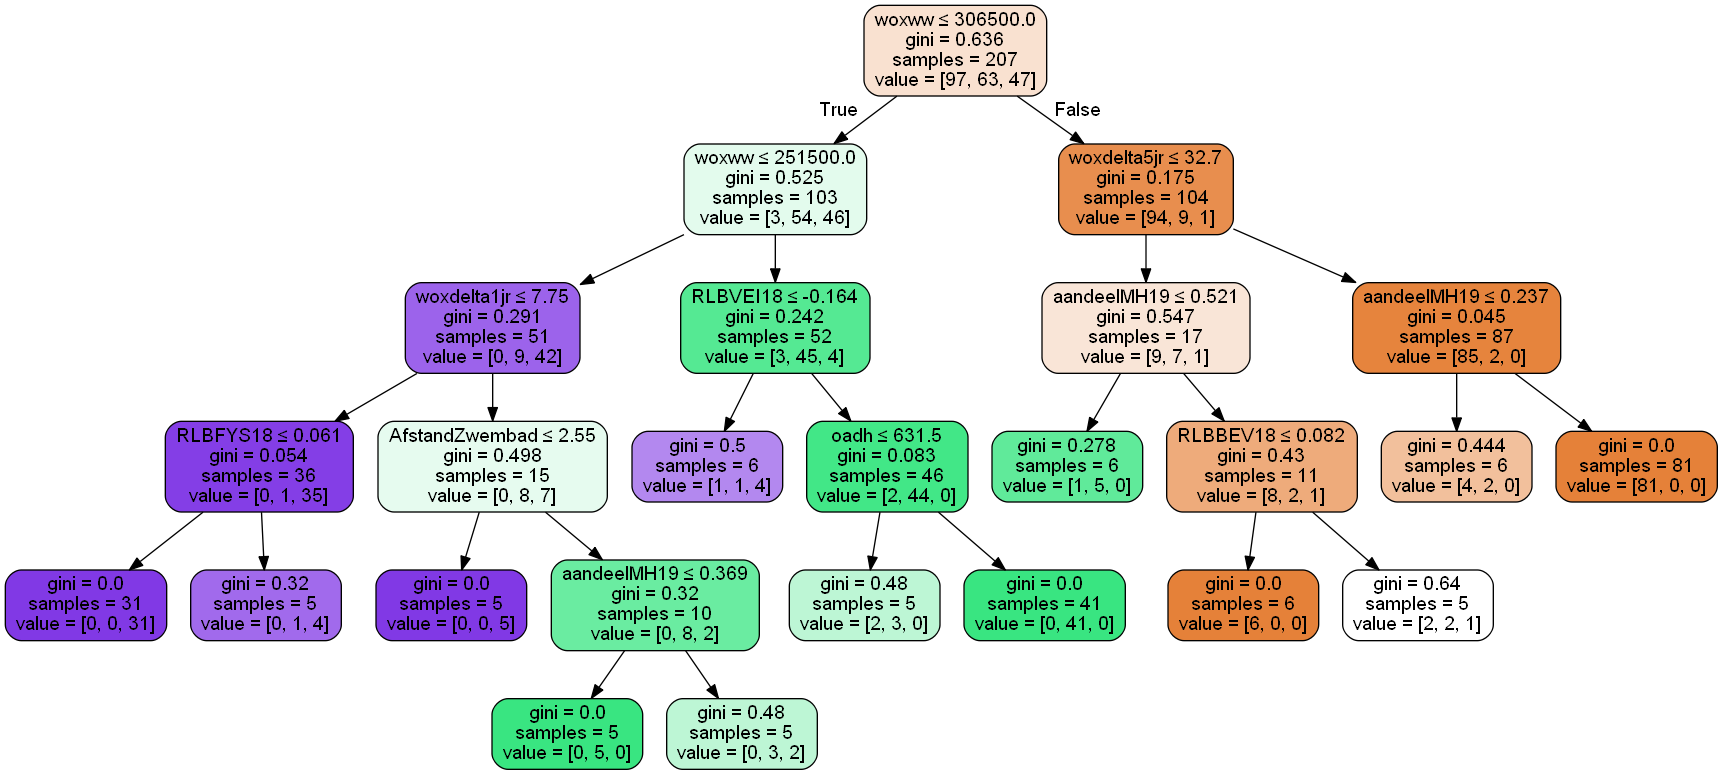

In [6]:
# EE met een weloverwogen selectie aan feature columns
# resultaat: hoge accuracy. Herkenbare boom muv zwembad onderin. met deze boom willen we verder gaan. Wel valt op dat variatie met random in sommige takken iets anders oplevert. 
# dat komt omdat features allemaal even belangrijk blijken na de eerste 4. We gaan voor random =7.
diepte=6
minleafsize=5
expert='EE'
testaandeel = 0.3
random = 7
# alle kolommen! behalve enkele omschhrijvingen, onnodige wijkcodes, marktpotentie want String 
feature_cols = ['buurtcode', 'bevdh', 'oadh', 
                'KL18', 'RLBRMTR18', 'RLBWON18', 'RLBBEV18', 'RLBVRZ18', 'RLBVEI18', 'RLBFYS18', 
                'AfstandSupermarkt', 'AantalLevensm3','AfstandZwembad', 'AantalPodiumk10',
                'aandeelMH19', 
                'auto30', 'ov30', 'fiets', 'banen',
                'wox', 'woxdelta1jr', 'woxdelta5jr', 'woxww', 'woxm2', 
                'woxdelta5jrWGrel', 'woxm2WG'] 


omschrijving =' d6 l5 sel EE 9 '
clf=maakTree(feature_cols, diepte, minleafsize, expert, testaandeel, random, omschrijving)
# statement om Image af te drukken moet buiten de method
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=feature_cols)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [7]:
# clf die het is geworden wederom toepassen op gehele dataset. 
# Eerst rijen met missing values uitsluiten en alleen de feature columns gebruiken. 
# LET OP. Er wordt dus geen oordeel gegeven op rijen waarvoor dat niet mogelijk is. Dat betekent ook dat de resultaaat
# dataset niet compleet is.
X_alles = dfAlles[feature_cols].dropna()
print('Aantal buurten dat een oordeel heeft gekregen: ', len(X_alles), 'van totaal: ', len(dfAlles))
# classifier toepassen op overblijvende dataset
allepred=clf.predict(X_alles)
# samenvoegen. alle pred is een array, maak er een dataframe van
allepreddf = pd.DataFrame(allepred)
# kolomnaam geven
allepreddf.columns=['voorspeld']
#drop index anders gaat mergen fout
X_alles.reset_index(drop=True, inplace=True)
# toevoegen voorspelde Y
voorspeldAlles = pd.concat([X_alles, allepreddf], axis=1)

Aantal buurten dat een oordeel heeft gekregen:  5686 van totaal:  13624


In [33]:
## decision tree nabootsen met if then statements
grenswwhoog = 306500
grenswwlaag = 251500
grens5jr = 32.7
grens1jr = 7.75
grensmh = 0.521
grenslbhvei = -0.164

# voorspeldAlles mee door gaan. Dit zijn de buurten die door de clf een oordeel hebben kunnen krijgen.
df = voorspeldAlles

# 5 nieuwe kolommen obv deze 6 grenzen
df['woxcat'] = np.where(df['woxww']>grenswwhoog, 'hoog', np.where(df['woxww']<= grenswwlaag, 'laag', 'midden'))
df['delta1jr'] = np.where(df['woxdelta1jr'] > grens1jr, 'snel', 'langzaam')
df['delta5jr'] = np.where(df['woxdelta5jr'] > grens5jr, 'snel', 'langzaam')
df['veilig'] = np.where(df['RLBVEI18'] > grenslbhvei, 'veilig', 'onveilig')
df['inkomens'] = np.where(df['aandeelMH19']>grensmh, 'rijk', 'arm')

# elke verschillende route afleiden
df['A'] = np.where((df['woxcat'] == 'hoog')   & (df['delta5jr'] == 'snel'), 'A',
                     np.where((df['woxcat'] == 'hoog')   & ((df['delta5jr'] == 'langzaam') & (df['inkomens'] == 'rijk')), 'A', ''))
df['C'] = np.where((df['woxcat'] == 'laag')   & (df['delta1jr'] == 'langzaam'), 'C', 
                     np.where((df['woxcat'] == 'midden') & (df['veilig']  == 'onveilig'), 'C', ''))
df['oordeel'] = np.where((df['A'] == 'A'), 'A', np.where((df['C'] == 'C'), 'C', 'B'))

# vergelijk met clf uitkomst: in eerste instantie door zwembad tak
afwijking = df[df['voorspeld'].str.upper()  != df['oordeel']]
print(afwijking.head())
print('aantal afwijkingen: ', len(afwijking))


#Nogmaals een kolom oordeel maken met wat afgerondere grenzen
grenswwhoog = 305000
grenswwlaag = 250000
grens5jr = 32
grens1jr = 7.5
grensmh = 0.5
grenslbhvei = -0.164

# 5 nieuwe kolommen obv deze 6 grenzen
df['woxcatX'] = np.where(df['woxww']>grenswwhoog, 'hoog', np.where(df['woxww']<= grenswwlaag, 'laag', 'midden'))
df['delta1jrX'] = np.where(df['woxdelta1jr'] > grens1jr, 'snel', 'langzaam')
df['delta5jrX'] = np.where(df['woxdelta5jr'] > grens5jr, 'snel', 'langzaam')
df['veiligX'] = np.where(df['RLBVEI18'] > grenslbhvei, 'veilig', 'onveilig')
df['inkomensX'] = np.where(df['aandeelMH19']>grensmh, 'rijk', 'arm')

# elke verschillende route afleiden
df['AX'] = np.where((df['woxcatX'] == 'hoog')   & (df['delta5jrX'] == 'snel'), 'A',
                     np.where((df['woxcatX'] == 'hoog')   & ((df['delta5jrX'] == 'langzaam') & (df['inkomensX'] == 'rijk')), 'A', ''))
df['CX'] = np.where((df['woxcatX'] == 'laag')   & (df['delta1jrX'] == 'langzaam'), 'C', 
                     np.where((df['woxcatX'] == 'midden') & (df['veiligX']  == 'onveilig'), 'C', ''))
df['oordeelX'] = np.where((df['AX'] == 'A'), 'A', np.where((df['CX'] == 'C'), 'C', 'B'))

# vergelijk met clf uitkomst: verschillen komen nu door afrondingen en niet door zwembad tak
afwijking = df[df['oordeel'] != df['oordeelX']]
print(afwijking.head())
print('aantal afwijkingen met en zonder rondere grenzen: ', len(afwijking))

df.to_excel(save_path +'\\Bomen\\df resultaat.xlsx')

     buurtcode    bevdh    oadh  KL18  RLBRMTR18  RLBWON18  RLBBEV18  \
128     801001   9012.0  4242.0   7.0   0.082654  0.108729  0.069146   
129     801002   4418.0  3884.0   8.0   0.137688  0.041943  0.058450   
130     801003   3273.0  4342.0   8.0   0.133549  0.034092  0.060913   
131     801004   8964.0  4498.0   6.0  -0.002710  0.061947  0.047834   
132     801005  11492.0  4514.0   6.0  -0.048210  0.064213  0.040847   

     RLBVRZ18  RLBVEI18  RLBFYS18    ...     C  oordeel  woxcatX  delta1jrX  \
128  0.228772 -0.318206 -0.005786    ...              B     laag       snel   
129  0.225479 -0.220730  0.032546    ...              B     laag       snel   
130  0.212091 -0.189425  0.015878    ...              B     laag       snel   
131  0.207362 -0.248252 -0.071601    ...              B     laag       snel   
132  0.207281 -0.277385 -0.083166    ...              B     laag       snel   

     delta5jrX   veiligX  inkomensX  AX  CX  oordeelX  
128       snel  onveilig        arm 

### Decision tree voor de buurten zonder WOX kolommen
Kan gebaseerd op alle buurten, maar zal worden toegepast op alleen buurten zonder WOX kolommen


Aantal rijen uit expert dataset dat gebruikt wordt:  296 van totaal aantal rijen:  338
Accuracy:  0.797752808988764 bij variant:   noWOXmin d4 l10 r8 EE 
Aantal buurten dat een oordeel heeft gekregen:  10441 van totaal:  13624


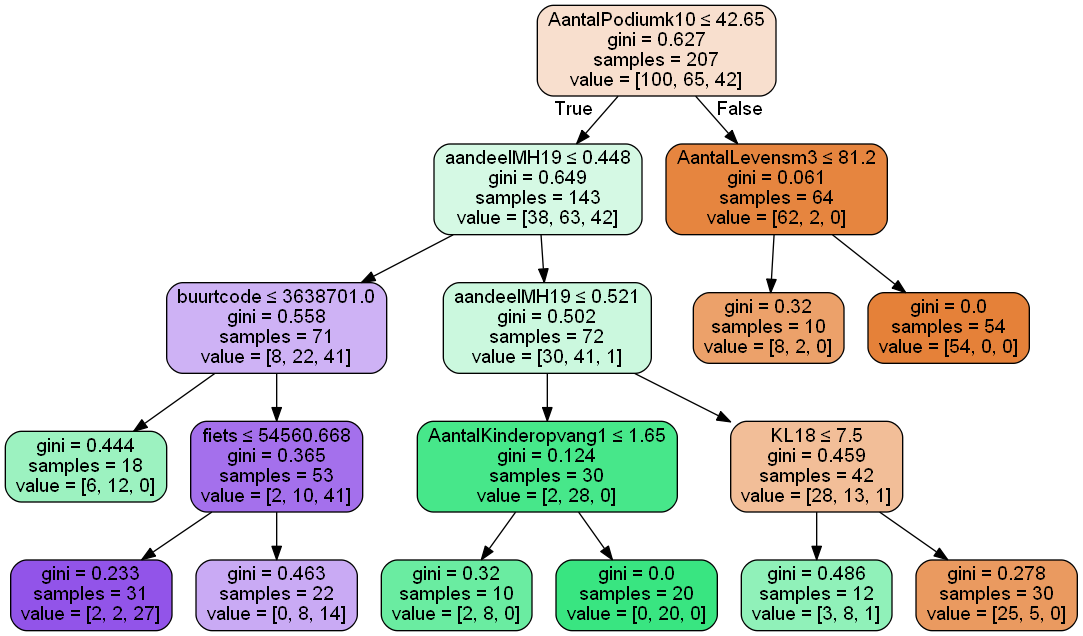

In [61]:
diepte=4
minleafsize=10
expert='EE'
testaandeel = 0.3
random = 8
# weloverwogen selectie sowieso zonder WOX
feature_cols = ['buurtcode', 'inw', 'bevdh', 'oadh', 'hh', 'KL18',
                'RLBRMTR18', 'RLBWON18', 'RLBBEV18', 'RLBVRZ18', 'RLBVEI18', 'RLBFYS18', 
              'AfstandSupermarkt', 'AantalLevensm3', 'AfstandHuisarts', 'AantalCafe3','AantalRest3', 'AantalKinderopvang1', 
                'AfstandZwembad', 'AantalMusea10',  'AantalPodiumk10', 'AantalBios5', 
               'aandeelMH19', 'auto30', 'ov30', 'fiets','banen'] 
'''alles excl WOX
feature_cols = ['buurtcode','inw', 'bevdh', 'oadh', 'hh', 'inw65', 'KL16', 'KL18', 'VKL1618',
                'RLBRMTR18', 'RLBWON18', 'RLBBEV18', 'RLBVRZ18', 'RLBVEI18', 'RLBFYS18', 
              'AfstandSupermarkt', 'AantalLevensm3', 'AfstandHuisarts', 'AantalCafe3','AantalRest3', 'AantalKinderopvang1', 
                'AfstandZwembad', 'AantalMusea10',  'AantalPodiumk10', 'AantalBios5', 
                'hh19inkLaag', 'hh30inkLaag', 'hh19inkMidden', 'hh30inkMidden', 'hh19inkHoog', 'hh30inkHoog', 
             'aandeelMH19', 'auto30', 'auto60', 'ov30', 'ov60', 'fiets','banen'] 
'''
omschrijving =' noWOXmin d4 l10 r8 EE '
clf=maakTree(feature_cols, diepte, minleafsize, expert, testaandeel, random, omschrijving)
# statement om Image af te drukken moet buiten de method
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=feature_cols)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [62]:
# clf die het is geworden wederom toepassen op gehele dataset. 
# Eerst rijen met missing values uitsluiten en alleen de feature columns gebruiken. 
# LET OP. Er wordt dus geen oordeel gegeven op rijen waarvoor dat niet mogelijk is. Dat betekent ook dat de resultaaat
# dataset niet compleet is.
X_alles = dfAlles[feature_cols].dropna()
print('Aantal buurten dat een oordeel heeft gekregen: ', len(X_alles), 'van totaal: ', len(dfAlles))
# classifier toepassen op overblijvende dataset
allepred=clf.predict(X_alles)
# samenvoegen. alle pred is een array, maak er een dataframe van
allepreddf = pd.DataFrame(allepred)
# kolomnaam geven
allepreddf.columns=['voorspeld']
#drop index anders gaat mergen fout
X_alles.reset_index(drop=True, inplace=True)
# toevoegen voorspelde Y
voorspeldAlles = pd.concat([X_alles, allepreddf], axis=1)

Aantal buurten dat een oordeel heeft gekregen:  10441 van totaal:  13624


In [63]:
## decision tree combi van 8 en 9 en vereenvoudigd. nabootsen met if then statements. meteen al afronden want afwijking meteen al.
grenspk = 42
grensmhhoog = 0.55
grensmhlaag = 0.45

# voorspeldAlles mee door gaan. Dit zijn de buurten die door de clf een oordeel hebben kunnen krijgen.
df = voorspeldAlles

# 2 nieuwe kolommen obv de 3 grenzen
df['pk'] = np.where(df['AantalPodiumk10']>grenspk, 'podiums', 'geenpodiums')
df['inkomens'] = np.where(df['aandeelMH19']>grensmhhoog, 'rijk', np.where(df['aandeelMH19']< grensmhlaag, 'arm', 'midden'))

# afleiden oordeel
df['oordeel'] = np.where((df['pk'] == 'podiums'), 'A', np.where(df['inkomens'] == 'arm', 'C', np.where(df['inkomens']=='rijk', 'A', 'B')))

# vergelijk met clf uitkomst
afwijking = df[df['voorspeld'].str.upper()  != df['oordeel']]
print(afwijking.head())
print('aantal afwijkingen tov voorspelling ', len(afwijking))

df.to_excel(save_path +'\\Bomen\\df zonder wox resultaat.xlsx')

   buurtcode   inw   bevdh    oadh    hh  KL18  RLBRMTR18  RLBWON18  RLBBEV18  \
0      30000  2370  2812.0  1210.0  1315   6.0  -0.051487  0.008156  0.033864   
1      30001  3035  1922.0   903.0  1335   6.0  -0.045828 -0.024550  0.048271   
2      30002  5725  2012.0  1140.0  2665   6.0  -0.185803 -0.076795 -0.005198   
4      30009   160    22.0   158.0    60   6.0  -0.040922  0.064967 -0.008142   
5     100202  1025  4650.0  1236.0   475   6.0  -0.102188 -0.026407  0.068491   

   RLBVRZ18   ...     AantalBios5  aandeelMH19         auto30          ov30  \
0 -0.100124   ...             0.0     0.272059  100149.700000  10454.300000   
1 -0.124013   ...             0.0     0.416058  104746.875000   6666.875000   
2 -0.114426   ...             0.0     0.254545   94492.750000  10386.937500   
4 -0.160330   ...             0.0     0.428571  110286.666667  10887.333333   
5 -0.315426   ...             0.0     0.272727   53226.750000   8249.250000   

          fiets         banen  voorspe

### decison tree opbouw die woxm2 voorspelt ipv oordeel. dit is evt tzt te gebruiken voor huurprijzen. 
Hier geen Classifier maar Regressor. Geen opvolging. 

In [73]:
# aanwijzen dependent en independent variabelen. Dit nog aanpassen naar de gehele dataset want geen expert mening nodig. 
feature_cols = ['oadh', 'AfstandSupermarkt', 'AantalLevensm3', 'AantalRest3', 'AantalPodiumk10', 'banen', 
             'woxdelta5jr', 'woxdelta5jrWGrel']
X = df[feature_cols] # features
yw = df.woxm2 # target variable woxm2

# Split dataset into training set and test set
Xw_train, Xw_test, yw_train, yw_test = train_test_split(X, yw, test_size=0.3, random_state=5) # 70% training and 30% test

In [78]:
# Maak Decision Tree classifier objecten
clfw = DecisionTreeRegressor(max_depth=3)

# Train Decision Tree Classifiers
clfw = clfw.fit(Xw_train,yw_train)

# Maak predicties
yw_pred = clfw.predict(Xw_test)

# evalueer de resultaten gemiddelde afwijking van woxm2 voorspeld en daadwerkelijk
print("Mean absolute error: ", metrics.mean_absolute_error(yw_test, yw_pred))
print("Mean squared error:", metrics.mean_squared_error(yw_test, yw_pred))

Mean absolute error:  273.04008126376544
Mean squared error: 156362.5990796181


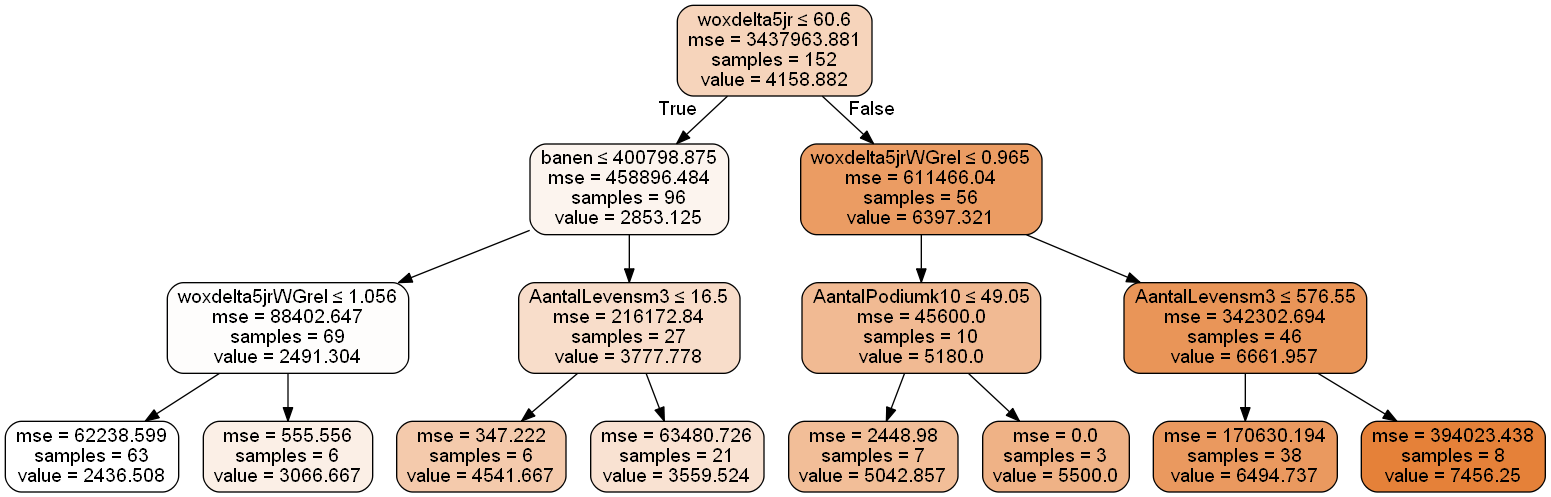

In [75]:
# visualisatie woxm2
dot_data = StringIO()

export_graphviz(clfw, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=feature_cols)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# hij gaat hier enorm overfitten, daarom max depth op 3 gezet